In [8]:
import numpy as np
from scipy.linalg import svd

# Function to compute the null space of a matrix
def null_space(A, rtol=1e-5):
    # Perform Singular Value Decomposition (SVD)
    u, s, vh = svd(A)
    
    # Find the rank of A based on the tolerance
    rank = (s > rtol * s[0]).sum()
    
    # The null space is the set of vectors in vh that correspond to zero singular values
    null_space_basis = vh[rank:].conj().T
    
    return null_space_basis

# Example matrix A (N x M)
A = np.array([[1, 0],
              [0, 1],
              [1, 1]])

# Transpose of A
A_transpose = A.T

# Find the null space of A transpose (this gives us C)
C = null_space(A_transpose)

# Show results
print("Matrix A:\n", A)
print("Transpose of A:\n", A_transpose)
print("Constraint matrix C (null space of A^T):\n", C)

Matrix A:
 [[1 0]
 [0 1]
 [1 1]]
Transpose of A:
 [[1 0 1]
 [0 1 1]]
Constraint matrix C (null space of A^T):
 [[-0.57735027]
 [-0.57735027]
 [ 0.57735027]]


Epoch [0/10000], Loss: 8.3530, Constraint Loss: 18.9341
Epoch [10/10000], Loss: 1.6413, Constraint Loss: 7.3739
Epoch [20/10000], Loss: 1.4831, Constraint Loss: 6.5463
Epoch [30/10000], Loss: 1.1105, Constraint Loss: 6.7458
Epoch [40/10000], Loss: 1.0081, Constraint Loss: 6.4404
Epoch [50/10000], Loss: 0.9940, Constraint Loss: 6.3800
Epoch [60/10000], Loss: 0.9807, Constraint Loss: 6.6365
Epoch [70/10000], Loss: 0.9823, Constraint Loss: 7.0705
Epoch [80/10000], Loss: 0.9670, Constraint Loss: 6.8380
Epoch [90/10000], Loss: 0.8511, Constraint Loss: 7.5213
Epoch [100/10000], Loss: 1.1760, Constraint Loss: 7.9017
Epoch [110/10000], Loss: 0.8022, Constraint Loss: 6.2573
Epoch [120/10000], Loss: 0.9418, Constraint Loss: 5.2061
Epoch [130/10000], Loss: 0.7792, Constraint Loss: 5.5952
Epoch [140/10000], Loss: 0.8275, Constraint Loss: 7.9495
Epoch [150/10000], Loss: 1.0168, Constraint Loss: 7.5955
Epoch [160/10000], Loss: 0.7876, Constraint Loss: 5.5219
Epoch [170/10000], Loss: 0.6617, Constrai

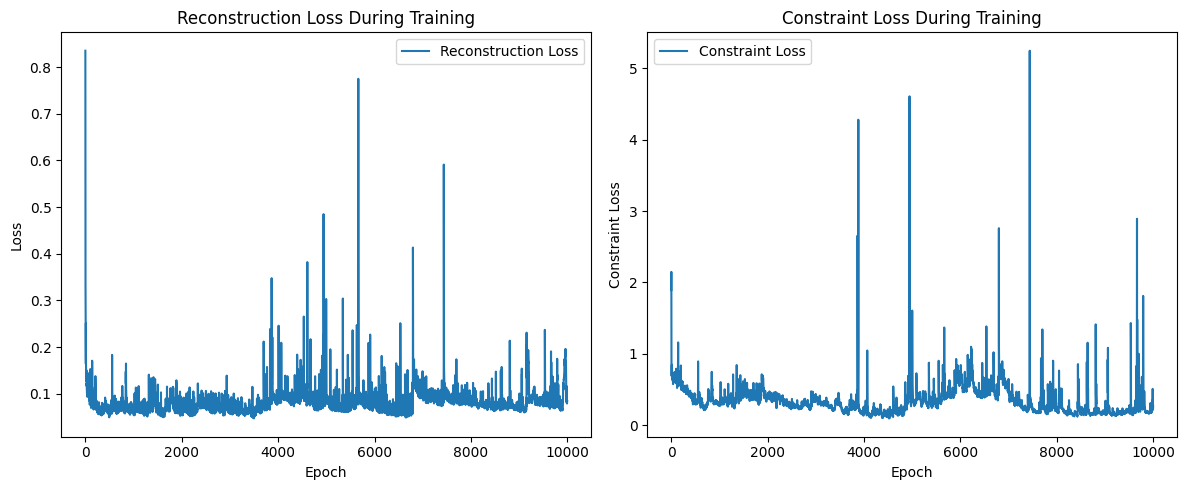

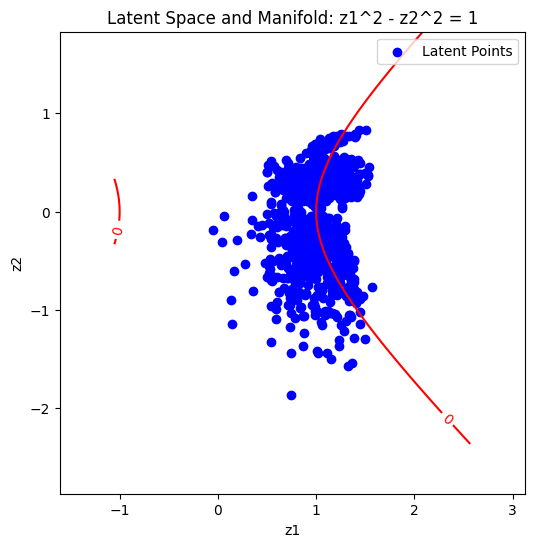

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Autoencoder Definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x, z

# Constraint Function: Forces latent space to satisfy z1^2 - z2^2 = 1
def constraint_loss(z):
    g1 = z[:, 0]**2 - z[:, 1]**2 - 1  # Hyperbola constraint: z1^2 - z2^2 = 1
    return torch.mean(g1**2)

# Training loop
def train_autoencoder(autoencoder, dataloader, epochs=100, lambda_coeff=1e-3, lr=1e-2):
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    loss_history = []
    constraint_history = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_constraint_loss = 0.0
        for data in dataloader:
            x = data  # input data
            
            # Forward pass
            recon_x, z = autoencoder(x)
            
            # Compute losses
            reconstruction_loss = nn.MSELoss()(recon_x, x)
            manifold_constraint_loss = constraint_loss(z)
            total_loss = reconstruction_loss + lambda_coeff * manifold_constraint_loss
            
            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            # Log losses
            epoch_loss += reconstruction_loss.item()
            epoch_constraint_loss += manifold_constraint_loss.item()
        
        # Record average losses for this epoch
        loss_history.append(epoch_loss / len(dataloader))
        constraint_history.append(epoch_constraint_loss / len(dataloader))

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}, Constraint Loss: {epoch_constraint_loss:.4f}')
    
    return loss_history, constraint_history

# Visualization function for training results
def visualize_training(loss_history, constraint_history):
    epochs = len(loss_history)
    
    # Plot Reconstruction Loss and Constraint Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Reconstruction Loss During Training")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), constraint_history, label="Constraint Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Constraint Loss")
    plt.title("Constraint Loss During Training")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualization function for the latent space
def visualize_latent_space(z):
    # Create a meshgrid for z1 and z2
    z1_range = np.linspace(np.min(z[:, 0]) - 1, np.max(z[:, 0]) + 1, 100)
    z2_range = np.linspace(np.min(z[:, 1]) - 1, np.max(z[:, 1]) + 1, 100)
    Z1, Z2 = np.meshgrid(z1_range, z2_range)

    # Compute the function F = z1^2 - z2^2 - 1 over the grid
    F = Z1**2 - Z2**2 - 1

    # Plot latent points
    plt.figure(figsize=(6, 6))
    plt.scatter(z[:, 0], z[:, 1], c='b', label="Latent Points")

    # Plot the contour where F = 0 (which corresponds to z1^2 - z2^2 = 1)
    manifold = plt.contour(Z1, Z2, F, levels=[0], colors='r')
    plt.clabel(manifold, inline=1, fontsize=10)

    # Add labels and legend
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space and Manifold: z1^2 - z2^2 = 1')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Synthetic Data Generation
def generate_synthetic_data(num_samples=1000, input_dim=3):
    # Random data for input, can be replaced with any dataset
    data = np.random.randn(num_samples, input_dim).astype(np.float32)
    return torch.tensor(data)

# Main
if __name__ == "__main__":
    # Define parameters
    input_dim = 3   # Dimensionality of input data
    latent_dim = 2  # Dimensionality of latent space
    num_samples = 10000
    batch_size = 1000
    epochs = 10000

    # Create synthetic data
    dataset = generate_synthetic_data(num_samples, input_dim)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize and train the autoencoder
    autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
    loss_history, constraint_history = train_autoencoder(autoencoder, dataloader, epochs=epochs, lambda_coeff=1e-2)

    # Visualize training results
    visualize_training(loss_history, constraint_history)

    # Generate some latent space visualization
    sample_data = next(iter(dataloader))
    _, z = autoencoder(sample_data)
    z = z.detach().numpy()  # Detach tensor from computation graph before converting to NumPy

    # Visualize the latent space with the manifold constraint
    visualize_latent_space(z)

/Users/home/Work/dev/py-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([20, 32, 1000])


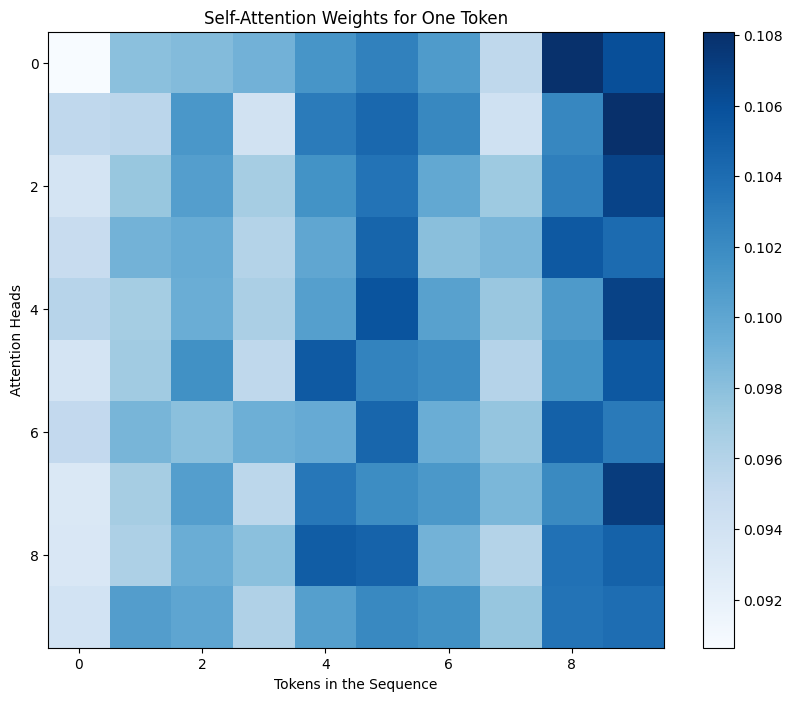

In [37]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# Set device for computation (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Positional Encoding to inject information about the relative positions of tokens
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

# 2. Transformer Model (Encoder-Decoder architecture)
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_len, output_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
        self.fc_out = nn.Linear(d_model, output_size)
        self.d_model = d_model

    def forward(self, src, tgt):
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)
        
        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)
        
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

# Hyperparameters
input_size = 1000    # Vocabulary size
output_size = 1000   # Same as input_size for translation tasks
d_model = 512        # Embedding size
nhead = 8            # Number of attention heads
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
max_len = 100

# Initialize the Transformer model
model = TransformerModel(input_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_len, output_size).to(device)

# Sample input
src = torch.randint(0, input_size, (10, 32)).to(device)  # (sequence_length, batch_size)
tgt = torch.randint(0, input_size, (20, 32)).to(device)  # (sequence_length, batch_size)

# Forward pass
output = model(src, tgt)
print(output.shape)  # Should output the shape (sequence_length, batch_size, output_size)
class SimpleAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(SimpleAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead)
    
    def forward(self, query, key, value):
        attn_output, attn_weights = self.multihead_attn(query, key, value)
        return attn_output, attn_weights

# Sample inputs
src = torch.rand(10, 32, d_model).to(device)  # (sequence_length, batch_size, d_model)

# Initialize the attention layer
attention = SimpleAttention(d_model, nhead).to(device)

# Pass the source tokens through the self-attention layer
attn_output, attn_weights = attention(src, src, src)

# Visualize attention weights for one token in the sequence
plt.figure(figsize=(10, 8))
plt.title("Self-Attention Weights for One Token")
plt.imshow(attn_weights[0, :, :].cpu().detach().numpy(), cmap='Blues')
plt.xlabel("Tokens in the Sequence")
plt.ylabel("Attention Heads")
plt.colorbar()
plt.show()

In [38]:
# A small toy dataset for translation (numbers -> text)
src_vocab = {0: "zero", 1: "one", 2: "two", 3: "three", 4: "four", 5: "five"}
tgt_vocab = {0: "cero", 1: "uno", 2: "dos", 3: "tres", 4: "cuatro", 5: "cinco"}

# Create some sample data (toy example)
src_sample = torch.tensor([[0, 1, 2, 3, 4]]).to(device)  # "zero one two three four"
tgt_sample = torch.tensor([[0, 1, 2, 3, 4]]).to(device)  # "cero uno dos tres cuatro"

# Forward pass through the model
output = model(src_sample.T, tgt_sample.T)

# Convert output to text using the target vocabulary
predicted_indices = torch.argmax(output, dim=-1).cpu().numpy()

# Print the translation
predicted_sentence = [tgt_vocab[idx] for idx in predicted_indices[:, 0]]
print(f"Predicted translation: {' '.join(predicted_sentence)}")

KeyError: np.int64(124)